### Prepare data

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('https://raw.githubusercontent.com/rasbt/'
                 'python-machine-learning-book-3rd-edition/'
                 'master/ch10/housing.data.txt',
                 header=None,
                 sep='\s+')

df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 
              'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

X = df[['RM']].values
y = df['MEDV'].values

In [5]:
import matplotlib.pyplot as plt 

def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)    
    return 

### Using scikit-learn

In [2]:
from sklearn.linear_model import LinearRegression

slr = LinearRegression()
slr.fit(X, y)
y_pred = slr.predict(X)
print('Slope: %.3f' % slr.coef_[0])
print('Intercept: %.3f' % slr.intercept_)

Slope: 9.102
Intercept: -34.671


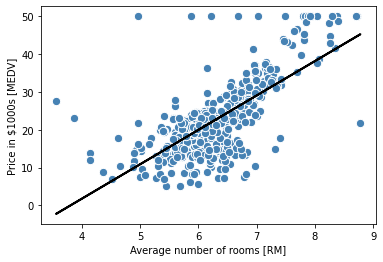

In [6]:
lin_regplot(X, y, slr)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')

#plt.savefig('images/10_07.png', dpi=300)
plt.show()

### Using normal equation

Closed form linear regression solution of $\hat{y} = w^T \cdot \textbf{x}$ 

$w = (\textbf{X}^T \cdot \textbf{X})^{-1} \cdot \textbf{X}^T \cdot \textbf{y}$


In [9]:
import numpy as np

# adding a column vector of "ones"
Xb = np.hstack((np.ones((X.shape[0], 1)), X))
w = np.zeros(X.shape[1])
z = np.linalg.inv(np.dot(Xb.T, Xb))
w = np.dot(z, np.dot(Xb.T, y))

print('Slope: %.3f' % w[1])
print('Intercept: %.3f' % w[0])

Slope: 9.102
Intercept: -34.671


### using RANSAC

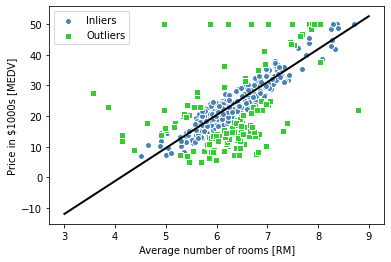

In [10]:
from sklearn.linear_model import RANSACRegressor

ransac = RANSACRegressor(LinearRegression(), 
                         max_trials=100, 
                         min_samples=50, 
                         loss='absolute_loss', 
                         residual_threshold=5.0, 
                         random_state=0)


ransac.fit(X, y)

inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='steelblue', edgecolor='white', 
            marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='limegreen', edgecolor='white', 
            marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='black', lw=2)   
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc='upper left')

#plt.savefig('images/10_08.png', dpi=300)
plt.show()

### Evaluating the performance of linear regression models

In [13]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, :-1].values
y = df['MEDV'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

slr = LinearRegression()

slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

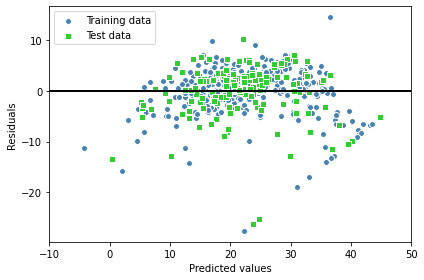

In [14]:
plt.scatter(y_train_pred,  y_train_pred - y_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')
plt.scatter(y_test_pred,  y_test_pred - y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, color='black', lw=2)
plt.xlim([-10, 50])
plt.tight_layout()

# plt.savefig('images/10_09.png', dpi=300)
plt.show()

### Scores MSE and $R^2$ 

* Mean Squared Error: $MSE = \frac{1}{n} \sum_{i=1}^{n} \left( y^{(i)} - \hat y ^{(i)} \right) ^ 2$
* Coefficient of dtermination: $R^2$ can be understood as a standardization version of the MSE. It is the fraction of the response variance that is captured by the model.

$R^2 = 1 - \frac{MSE}{Var(y)}  = 1 - \frac{\frac{1}{n} \sum_{i=1}^{n} \left( y^{(i)} - \hat y ^{(i)} \right) ^ 2}{\frac{1}{n} \sum_{i=1}^{n} \left( y^{(i)} - \mu_y \right) ^ 2}$



In [15]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 19.958, test: 27.196
R^2 train: 0.765, test: 0.673


### Modeling non-linear relationship

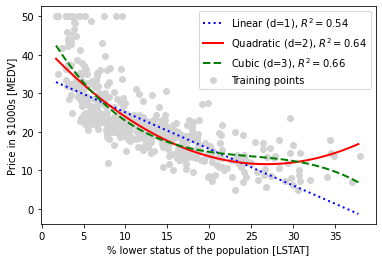

In [17]:
from sklearn.preprocessing import PolynomialFeatures

X = df[['LSTAT']].values
y = df['MEDV'].values

regr = LinearRegression()

# create quadratic features
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

# fit features
X_fit = np.arange(X.min(), X.max(), 1)[:, np.newaxis]

regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))


# plot results
plt.scatter(X, y, label='Training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, 
         label='Linear (d=1), $R^2=%.2f$' % linear_r2, 
         color='blue', 
         lw=2, 
         linestyle=':')

plt.plot(X_fit, y_quad_fit, 
         label='Quadratic (d=2), $R^2=%.2f$' % quadratic_r2,
         color='red', 
         lw=2,
         linestyle='-')

plt.plot(X_fit, y_cubic_fit, 
         label='Cubic (d=3), $R^2=%.2f$' % cubic_r2,
         color='green', 
         lw=2, 
         linestyle='--')

plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc='upper right')

#plt.savefig('images/10_12.png', dpi=300)
plt.show()